In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sqlalchemy as db

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import Adam

from IPython.display import clear_output

In [5]:
print("CUDA available", torch.cuda.is_available())
print("CUDA dev count", torch.cuda.device_count())
print("CUDA dev curr", torch.cuda.current_device())
print("CUDA dev", torch.cuda.device(0))
print("CUDA dev name", torch.cuda.get_device_name(0))

CUDA available True
CUDA dev count 1
CUDA dev curr 0
CUDA dev <torch.cuda.device object at 0x000001E10531A410>
CUDA dev name NVIDIA GeForce GTX 1650


Connection to DLSU Cloud DB (PAL)
- `connection.json` is abstracted for data privacy

Reading the Historical Data

In [6]:
conn = pd.read_json('connection.json', typ='series')
host = conn['host']
user = conn['user']
password = conn['password']
port = conn['port']
engine = db.create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + ':' + port + '/' + 'Historical')

def query_historical(table_name):
    query = f"SELECT * FROM {table_name}"
    hist = pd.read_sql(query, engine)
    hist.index = hist['index']
    hist.drop('index', axis=1, inplace=True)
    return hist

In [61]:
palb777 = query_historical('PALB777_hour')
pala321c = query_historical('PALA321C_hour')
gapa321c = query_historical('GAPA321C_hour')
gapa320 = query_historical('GAPA320_hour')

Exception during reset or similar
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\pymysql\connections.py", line 779, in _read_bytes
    data = self._rfile.read(num_bytes)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sqlalchemy\pool\base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sqlalchemy\pool\base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sqlalchemy\engine\default.py", line 682, in do_rollback
    dbapi_connection.rollback()
  Fi

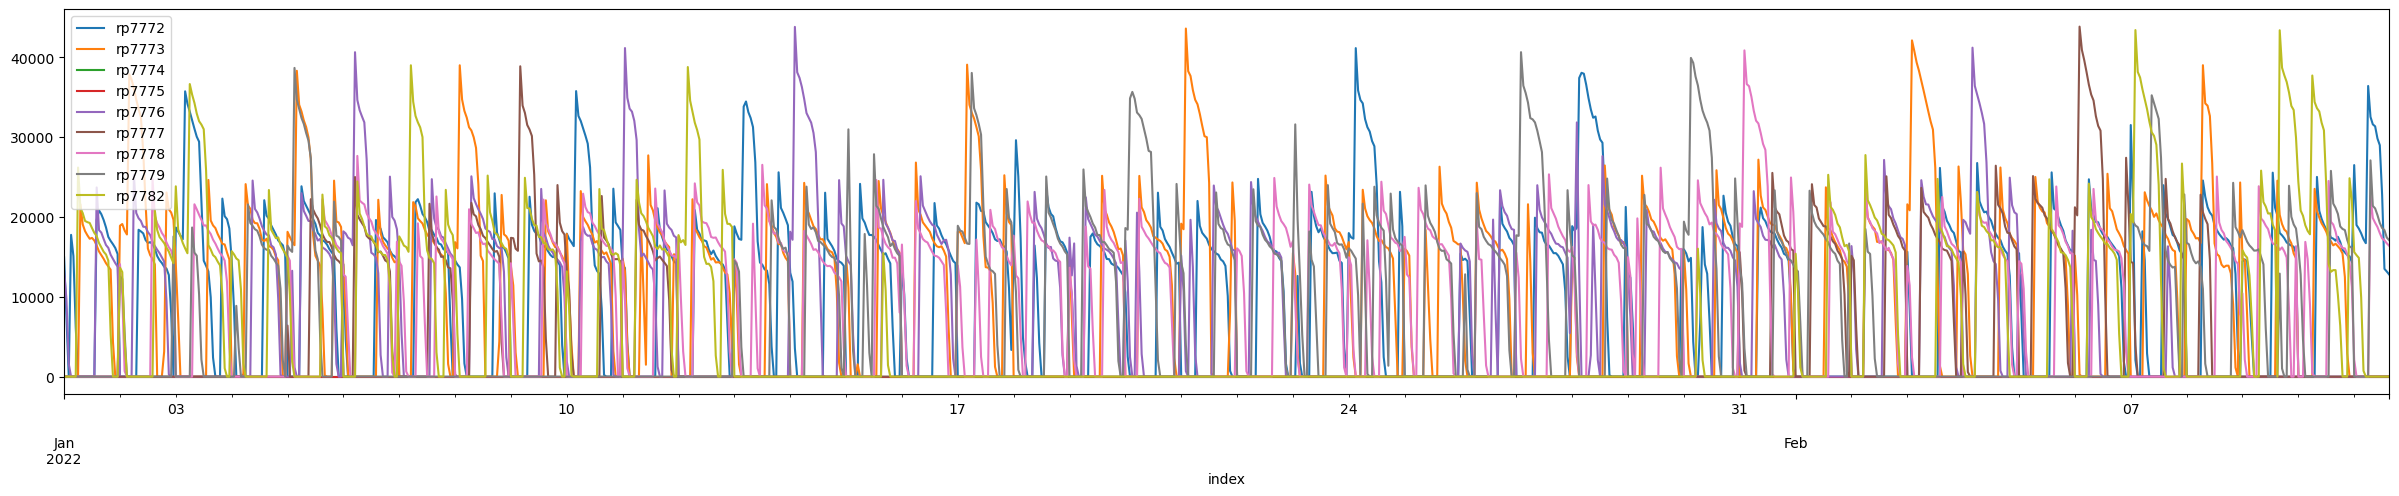

In [62]:
palb777[:1000].plot(figsize=(30,5))
plt.show()

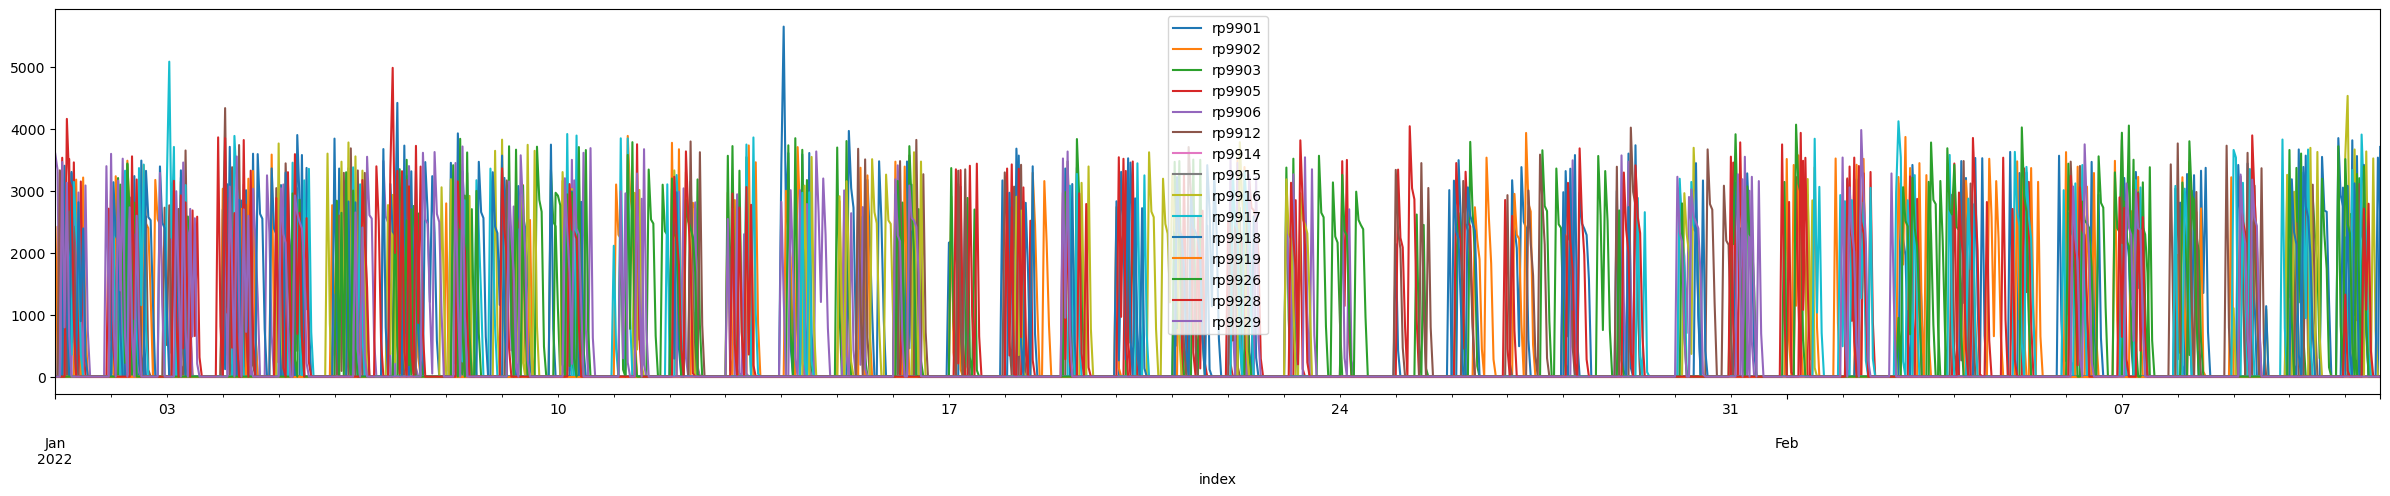

In [63]:
pala321c[:1000].plot(figsize=(30,5))
plt.show()

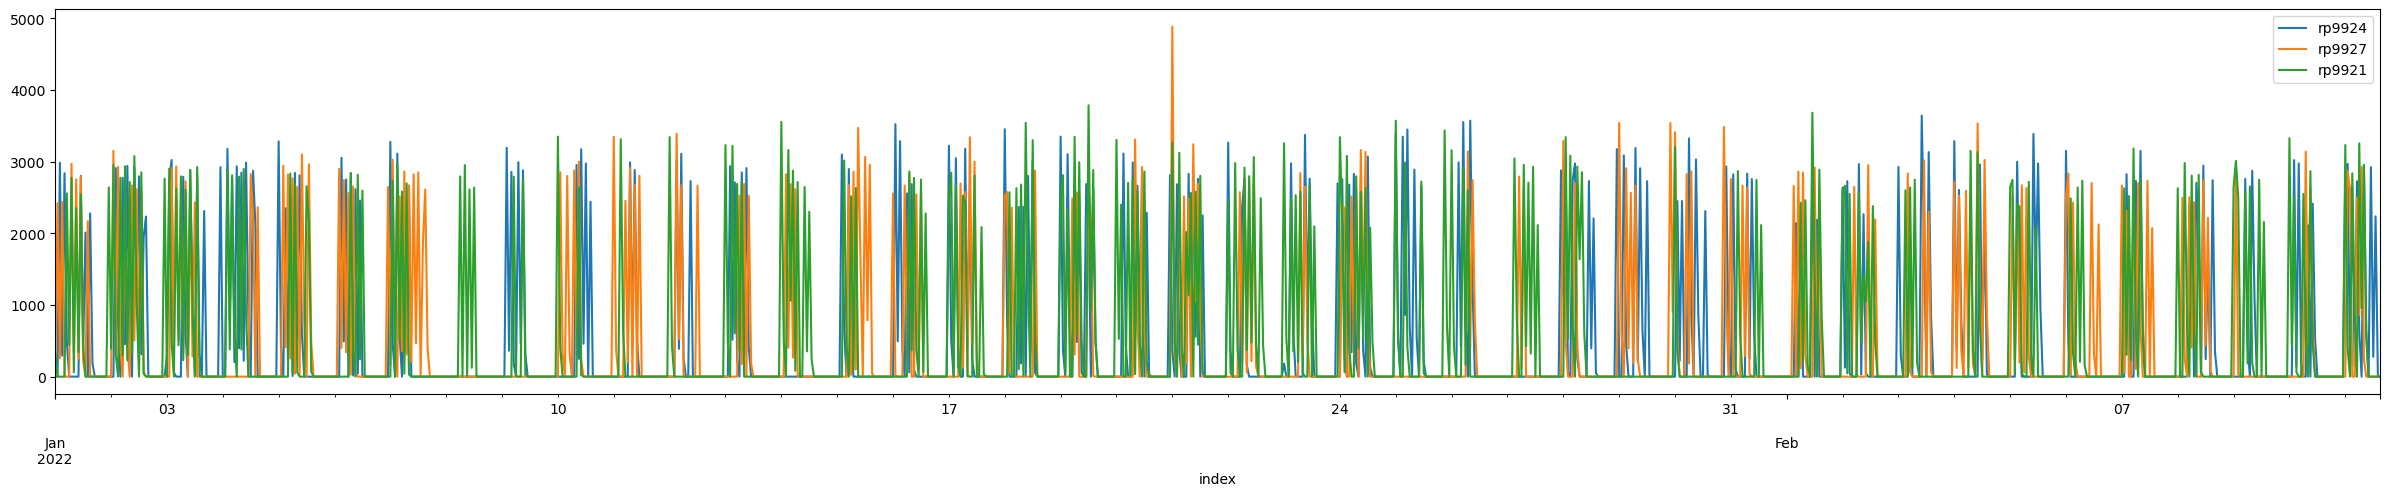

In [64]:
gapa321c[:1000].plot(figsize=(30,5))
plt.show()

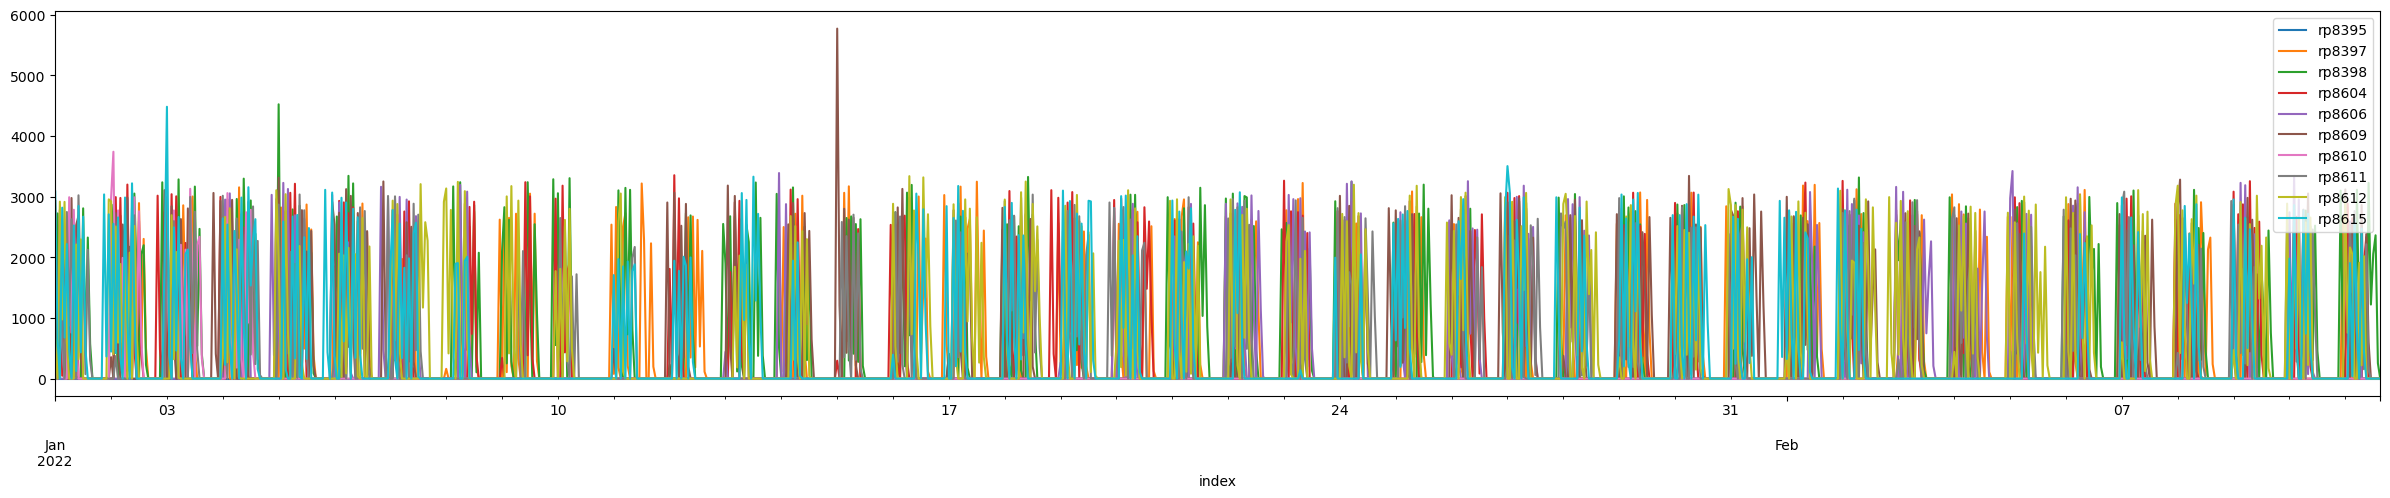

In [65]:
gapa320[:1000].plot(figsize=(30,5))
plt.show()

# EDA & Preprocessing

In [125]:
hist = pd.concat([ gapa321c, pala321c, gapa320], axis=1).fillna(0)

In [126]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2022-01-01 00:00:00 to 2023-01-01 00:00:00
Freq: H
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rp9924  8761 non-null   float64
 1   rp9927  8761 non-null   float64
 2   rp9921  8761 non-null   float64
 3   rp9901  8761 non-null   float64
 4   rp9902  8761 non-null   float64
 5   rp9903  8761 non-null   float64
 6   rp9905  8761 non-null   float64
 7   rp9906  8761 non-null   float64
 8   rp9912  8761 non-null   float64
 9   rp9914  8761 non-null   float64
 10  rp9915  8761 non-null   float64
 11  rp9916  8761 non-null   float64
 12  rp9917  8761 non-null   float64
 13  rp9918  8761 non-null   float64
 14  rp9919  8761 non-null   float64
 15  rp9926  8761 non-null   float64
 16  rp9928  8761 non-null   float64
 17  rp9929  8761 non-null   float64
 18  rp8395  8761 non-null   float64
 19  rp8397  8761 non-null   float64
 20  rp8398  8761 non-null   float6

In [127]:
hist.describe()

,rp9924,rp9927,rp9921,rp9901,rp9902,rp9903,rp9905,rp9906,rp9912,rp9914,...,rp8395,rp8397,rp8398,rp8604,rp8606,rp8609,rp8610,rp8611,rp8612,rp8615
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,...,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000
mean,807.586605,781.773305,240.839821,937.474209,857.830899,923.650339,770.119194,854.883685,921.163065,785.899122,...,443.388511,622.948068,678.923633,399.371758,492.168518,663.493589,383.946998,671.362136,691.019037,679.077751
std,1236.608419,1208.662882,757.773738,1351.132648,1286.247133,1314.767261,1270.189179,1298.613065,1318.576913,1287.417674,...,927.802434,1047.555812,1073.653223,900.179595,974.434388,1065.868944,884.305704,1079.165833,1089.543465,1094.135291
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1534.425278,1401.519444,0.000000,2232.550556,1862.034444,2233.453889,1192.475556,1804.953889,2270.235278,1323.771111,...,103.250000,706.264722,1027.285000,0.000000,324.771667,870.397500,0.000000,892.021667,964.688333,904.829444
max,7039.134444,6910.475000,3975.395000,7470.376667,7294.258889,7694.414444,7867.334444,6640.620000,6439.778333,8981.754722,...,5828.099444,5987.440000,5927.651667,6919.163333,6078.459167,6188.428333,5028.289444,6059.222222,6072.859167,6673.183333


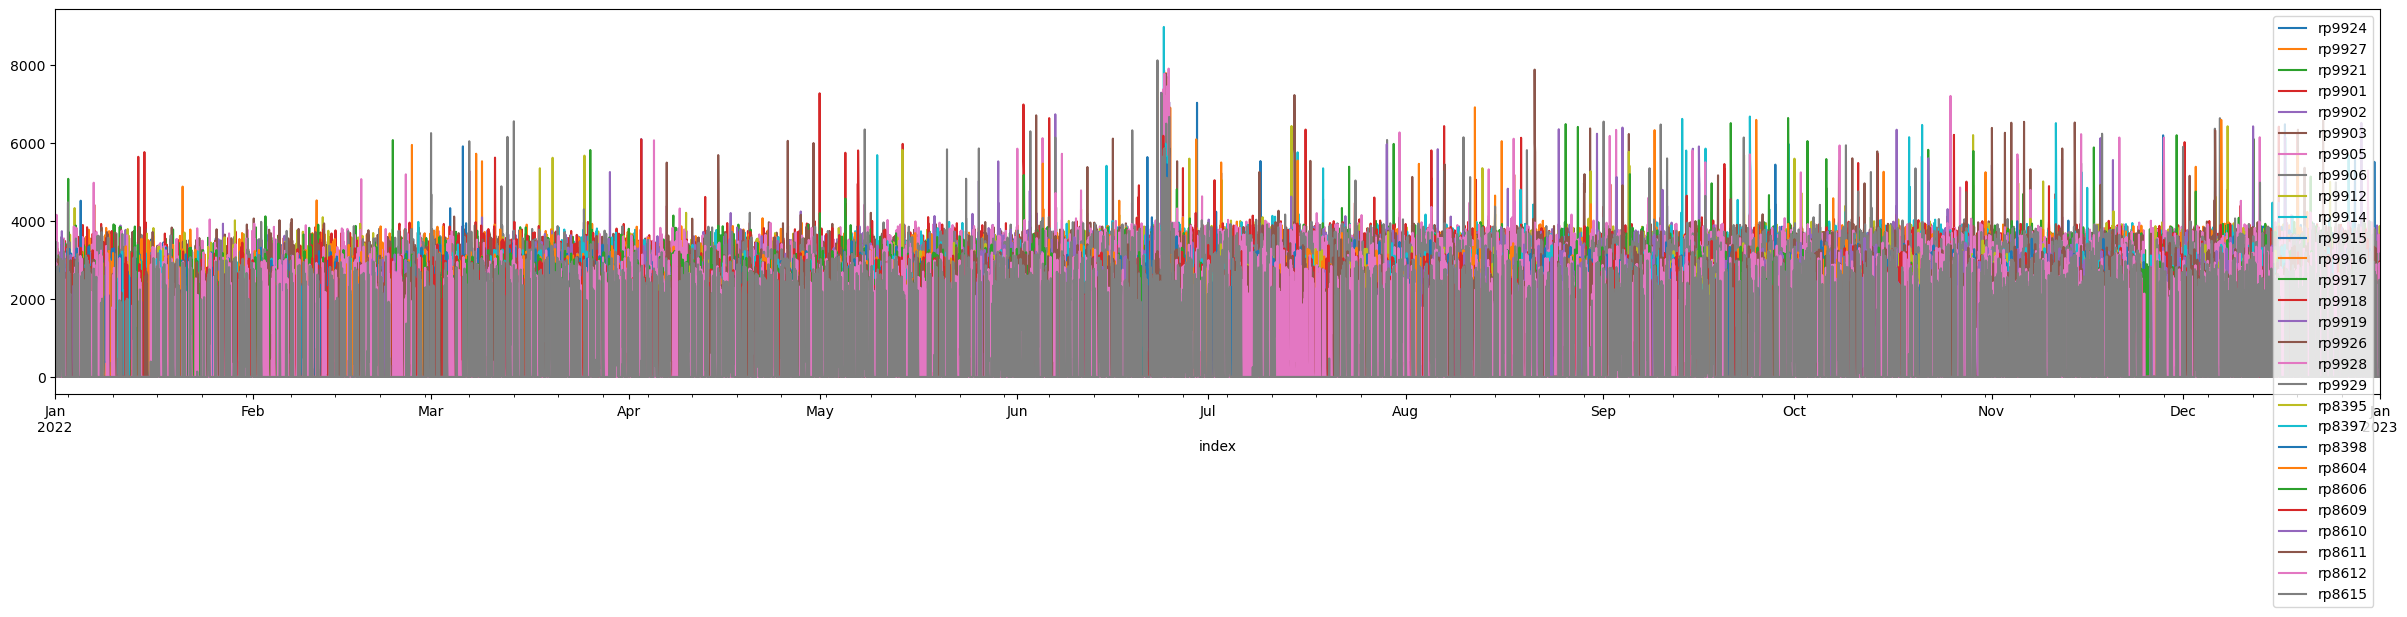

In [128]:
hist.plot(figsize=(30,5))
plt.show()

Data Aggregation

In [129]:
agg = input("Monthly [M], Weekly [W], Daily [D], Hourly [H]: ")
agg = agg.upper()
if agg == 'W':
    agg += '-' + hist.index[1].day_name()[:3]
placeholder = hist
hist = hist.resample(agg).sum()
inc23 = input('Include year 2023 (yes - Y):')
if inc23 != 'Y':
    hist = hist[:365*24]

Monthly [M], Weekly [W], Daily [D], Hourly [H]: h
Include year 2023 (yes - Y):y


In [130]:
hist

,rp9924,rp9927,rp9921,rp9901,rp9902,rp9903,rp9905,rp9906,rp9912,rp9914,...,rp8395,rp8397,rp8398,rp8604,rp8606,rp8609,rp8610,rp8611,rp8612,rp8615
index,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.000000,0.000000,346.748889,0.000000,0.000000,0.0,0.000000,3598.643889,0.000000,0.000000,...,0.0,1991.337222,0.000000,0.000000,0.000000,2927.575278,0.000000,0.000000,496.881111,3085.123611
2022-01-01 01:00:00,0.000000,2419.833056,0.000000,0.000000,2420.995833,0.0,0.000000,3338.322222,0.000000,0.000000,...,0.0,2532.665278,2723.728611,0.000000,0.000000,662.299444,0.000000,0.000000,0.000000,656.013611
2022-01-01 02:00:00,2985.678333,255.756111,0.000000,3300.336111,284.965000,0.0,0.000000,0.000000,3329.510556,0.000000,...,0.0,329.266667,383.339444,2198.761944,0.000000,2782.315833,2647.062222,2456.895000,2917.924722,0.000000
2022-01-01 03:00:00,294.136389,2439.583889,0.000000,2373.105833,2691.582778,0.0,3532.808056,2650.616389,1898.623889,0.000000,...,0.0,2504.536389,2537.589722,46.392500,0.000000,532.741944,612.722500,764.655556,974.955278,2818.859167
2022-01-01 04:00:00,2838.475556,0.000000,0.000000,2255.120278,344.581667,0.0,583.563333,20.331944,11.903611,0.000000,...,0.0,464.729722,435.879444,2252.848333,0.000000,0.000000,0.000000,0.000000,2914.008889,676.783056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.000000,0.000000,0.000000,2408.946944,0.000000,0.0,0.000000,2654.417222,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-12-31 20:00:00,3201.277500,0.000000,0.000000,815.407500,0.000000,0.0,0.000000,2436.098056,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-12-31 21:00:00,459.316667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,849.028333,0.000000,2672.311667,...,0.0,0.000000,0.000000,0.000000,2949.842500,0.000000,0.000000,2827.166667,2925.650278,2495.163889


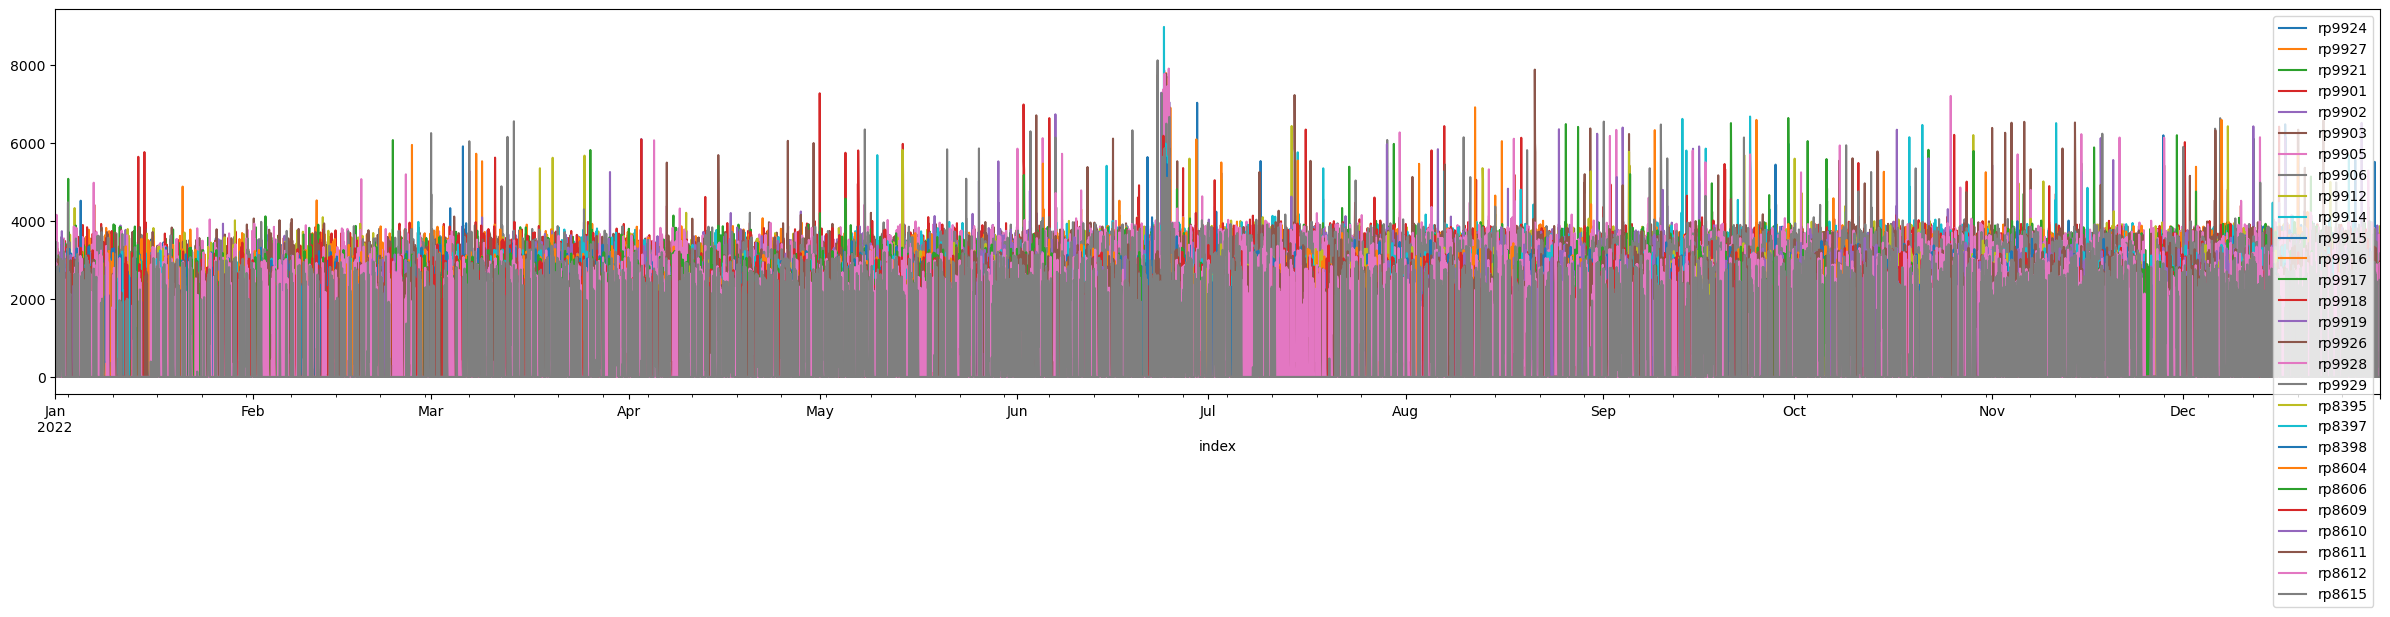

In [131]:
hist.plot(figsize=(30,5))
plt.show()

Separate the data

In [132]:
hist_list = []
for each in list(hist.columns):
    hist_list.append(hist[[each]])

Process the data

In [142]:
# ss = StandardScaler()
time_step = 16 # time step for preprocessing
pred_step = 1   # number of predictions

def time_step_prep(data, time_step,pred_step):
    X = []
    y = []
    for i in range(time_step, data.shape[0]-pred_step):
        X.append(list(data.iloc[i-time_step:i, 0].values.reshape(-1)))
        y.append(list(data.iloc[i:i+pred_step, 0].values.reshape(-1)))
    return X, y

In [143]:
X, y = np.array([[]]), np.array([[]])
for each in hist_list:
    X_n, y_n = time_step_prep(each, time_step, pred_step)
    if X.shape[1] == 0 and y.shape[1] == 0:
        X = np.array(X_n)
        y = np.array(y_n)
    else:
        X = np.concatenate([X, np.array(X_n)])
        y = np.concatenate([y, np.array(y_n)])

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True)

In [145]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(220323, 16)
(220323, 1)
(24481, 16)
(24481, 1)


Standardization

In [146]:
class Scaler:
    mean = 0.0
    std = 0.0
    def fit(self, X):
        self.mean = X.mean()
        self.std = X.std()
    def transform(self, X):
        return (X - self.mean)/self.std
    def inverse(self, X):
        return (X * self.std) + self.mean

In [147]:
ss = Scaler()
ss.fit(X_train)

X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
y_train = ss.transform(y_train)
y_test = ss.transform(y_test)

Convert the data to torch

In [148]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# Prediction Models

Construct Prediction Models

In [149]:
# LSTM based prediction model
class LSTM_based(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):        
        # forward propagate
        out, (h_,c_) = self.lstm(x)
        out = self.fc(out)
        return out
    
# RNN based prediction model
class RNN_based(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        
        # define the dimensions
        self.in_dim = in_dim
        self.hid_dim = in_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        # define the rnn layer
        self.rnn = nn.RNN(self.in_dim, self.hid_dim, self.layer, nonlinearity='relu', batch_first=True)
        
        # define fully connected layer for output
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        # forward propagate
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

# Simple Autoregressive Model
auto_reg = nn.Linear(time_step,pred_step)

# AR with Activation
auto_reg2 = nn.Sequential(
    nn.Linear(time_step, time_step // 2),
    nn.ReLU(),
    nn.Linear(time_step // 2, pred_step)
)

In [150]:
input_features = X_train.shape[-1]
hidden_size = 32
num_layers = 2
out_size = 1

# model = LSTM_based(input_features, hidden_size, out_size, num_layers)
# model = auto_reg
model = auto_reg2

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# loss_fun = nn.L1Loss()
loss_fun = nn.MSELoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.1)

In [151]:
train_loss = []
test_loss = []

def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               scheduler=None,
               epochs=500):
    
    global train_loss
    global test_loss
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred, y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        # scheduler
        if scheduler is not None:
            scheduler.step()
        
        if (epoch+1) % 5 ==0:
            print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
#     return train_loss, test_loss

In [152]:
train_model(
    model, 
    loss_fun,
    optimizer, 
    X_train, 
    X_test,
    y_train, 
    y_test,
    scheduler,
    2000
)

Epoch :0.0025    Train Loss :0.8716092109680176    Test Loss :0.8573148250579834
Epoch :0.005    Train Loss :0.8308331966400146    Test Loss :0.8517020344734192
Epoch :0.0075    Train Loss :0.8233197927474976    Test Loss :0.8336800932884216
Epoch :0.01    Train Loss :0.811222493648529    Test Loss :0.8236043453216553
Epoch :0.0125    Train Loss :0.7998045682907104    Test Loss :0.8110121488571167
Epoch :0.015    Train Loss :0.7856931090354919    Test Loss :0.7985841035842896
Epoch :0.0175    Train Loss :0.7736327052116394    Test Loss :0.7840164303779602
Epoch :0.02    Train Loss :0.7598984837532043    Test Loss :0.7734313011169434
Epoch :0.0225    Train Loss :0.7510329484939575    Test Loss :0.7639645934104919
Epoch :0.025    Train Loss :0.7464898824691772    Test Loss :0.7635095119476318
Epoch :0.0275    Train Loss :0.745694100856781    Test Loss :0.7671865820884705
Epoch :0.03    Train Loss :0.7426731586456299    Test Loss :0.7592785358428955
Epoch :0.0325    Train Loss :0.74071663

Epoch :0.2625    Train Loss :0.7266712784767151    Test Loss :0.7423168420791626
Epoch :0.265    Train Loss :0.7267127633094788    Test Loss :0.7423365116119385
Epoch :0.2675    Train Loss :0.727843701839447    Test Loss :0.7447243332862854
Epoch :0.27    Train Loss :0.7451274394989014    Test Loss :0.7620499730110168
Epoch :0.2725    Train Loss :0.7367665767669678    Test Loss :0.7508190870285034
Epoch :0.275    Train Loss :0.7309178113937378    Test Loss :0.7459443211555481
Epoch :0.2775    Train Loss :0.7282425165176392    Test Loss :0.7438194155693054
Epoch :0.28    Train Loss :0.7276173830032349    Test Loss :0.7431957721710205
Epoch :0.2825    Train Loss :0.7275713682174683    Test Loss :0.7435386180877686
Epoch :0.285    Train Loss :0.7271827459335327    Test Loss :0.7432683706283569
Epoch :0.2875    Train Loss :0.7269091010093689    Test Loss :0.7429875731468201
Epoch :0.29    Train Loss :0.7268528938293457    Test Loss :0.7427167892456055
Epoch :0.2925    Train Loss :0.7267299

Epoch :0.5225    Train Loss :0.7293155193328857    Test Loss :0.7452097535133362
Epoch :0.525    Train Loss :0.7273272275924683    Test Loss :0.743052065372467
Epoch :0.5275    Train Loss :0.7280517816543579    Test Loss :0.743677020072937
Epoch :0.53    Train Loss :0.7270188331604004    Test Loss :0.7429845929145813
Epoch :0.5325    Train Loss :0.7271489500999451    Test Loss :0.7428032755851746
Epoch :0.535    Train Loss :0.7267346978187561    Test Loss :0.7425304651260376
Epoch :0.5375    Train Loss :0.7269492745399475    Test Loss :0.7426117062568665
Epoch :0.54    Train Loss :0.7268301844596863    Test Loss :0.7424951195716858
Epoch :0.5425    Train Loss :0.7266873717308044    Test Loss :0.7423375844955444
Epoch :0.545    Train Loss :0.7266386151313782    Test Loss :0.7423131465911865
Epoch :0.5475    Train Loss :0.7266724705696106    Test Loss :0.7423537373542786
Epoch :0.55    Train Loss :0.7266594171524048    Test Loss :0.7423097491264343
Epoch :0.5525    Train Loss :0.72684401

Epoch :0.78    Train Loss :0.7266194224357605    Test Loss :0.7422905564308167
Epoch :0.7825    Train Loss :0.7266188263893127    Test Loss :0.7422960996627808
Epoch :0.785    Train Loss :0.7266186475753784    Test Loss :0.7422984838485718
Epoch :0.7875    Train Loss :0.7266185879707336    Test Loss :0.7422999739646912
Epoch :0.79    Train Loss :0.7266185879707336    Test Loss :0.7423046231269836
Epoch :0.7925    Train Loss :0.7266180515289307    Test Loss :0.7422937750816345
Epoch :0.795    Train Loss :0.7266179919242859    Test Loss :0.7423001527786255
Epoch :0.7975    Train Loss :0.7266179919242859    Test Loss :0.7423004508018494
Epoch :0.8    Train Loss :0.7266174554824829    Test Loss :0.7422907948493958
Epoch :0.8025    Train Loss :0.726617693901062    Test Loss :0.7422987222671509
Epoch :0.805    Train Loss :0.7266174554824829    Test Loss :0.7422939538955688
Epoch :0.8075    Train Loss :0.7266169786453247    Test Loss :0.7422885894775391
Epoch :0.81    Train Loss :0.7266169786

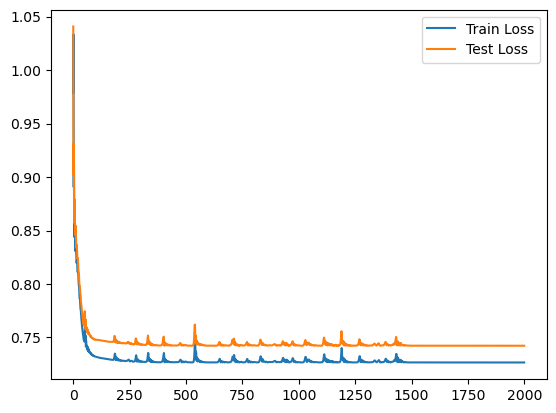

In [153]:
ax = plt.subplot()
ax.plot(train_loss, label='Train Loss')
ax.plot(test_loss, label='Test Loss')
ax.legend()

Single-step prediction

In [154]:
actual = pd.DataFrame(ss.inverse(y_test.detach().numpy().reshape(-1,1))).rename({0:'actual'},axis=1)
pred = pd.DataFrame(ss.inverse(model(X_test).detach().numpy())).rename({0:'single_pred'},axis=1)

<Axes: >

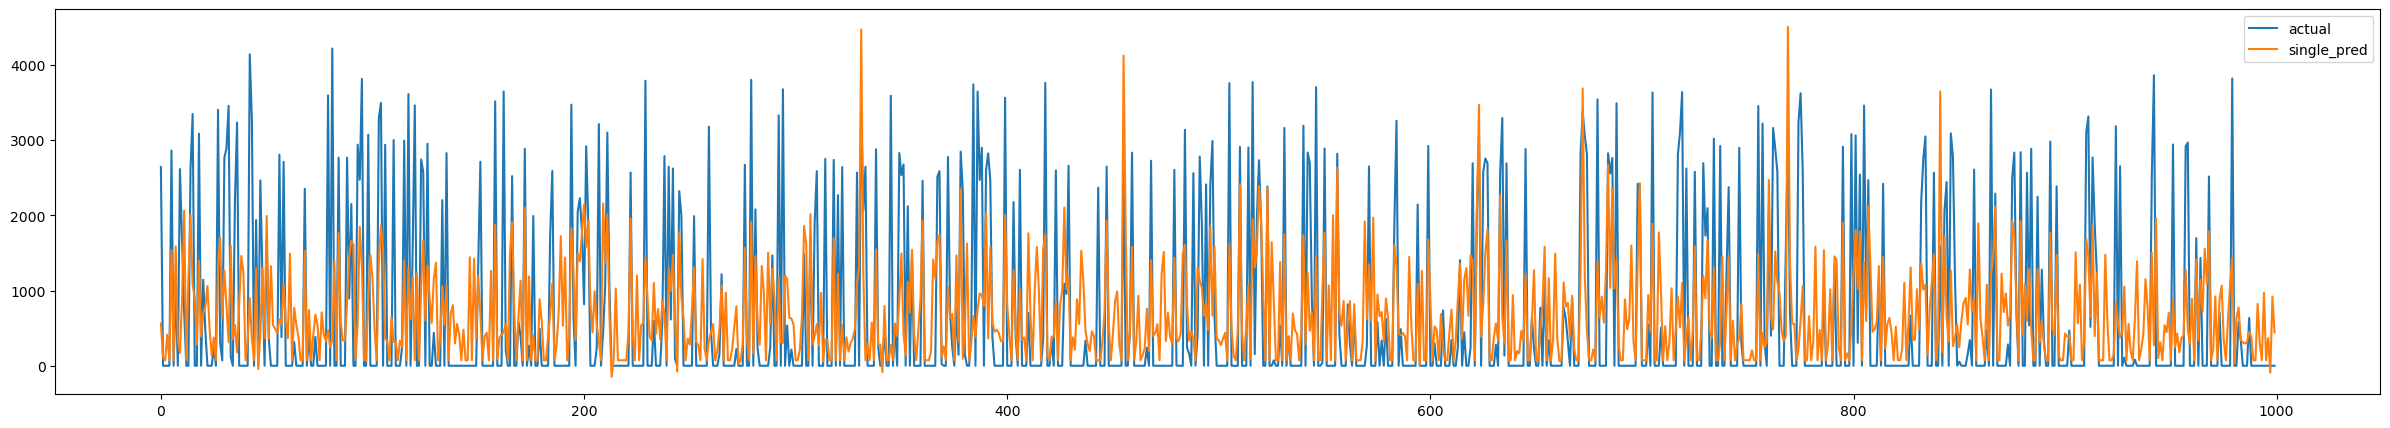

In [155]:
actual_pred = pd.concat([actual, pred], axis=1)
actual_pred[:1000].plot(figsize=(30,5))

In [156]:
rmse = float(np.sqrt(sum((actual.values - pred.values)**2)/len(actual)))
r2 = r2_score(actual, pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 1016.592529296875
R2: 0.26447245731596536


Recursive-step prediction

In [157]:
def recursive_step(i, pred_step, plot=True, ret='total', denorm=True):
    multi_pred = []
    currX = X_test[i]
    
    while len(multi_pred) != pred_step:
        tensor_pred = model(currX)
        currX = torch.cat([currX, tensor_pred])
        currX = currX[-time_step:]
        pred = ss.inverse(tensor_pred.detach().numpy().reshape(-1,1))
        multi_pred.append(float(pred))
    
    actual = y_test[i:i+pred_step].detach().numpy()
    multi_pred = np.array(multi_pred).reshape(-1,1)
    if denorm:
        actual = ss.inverse(actual)
    else:
        multi_pred = ss.transform(multi_pred)
    df = pd.DataFrame(np.concatenate([actual,multi_pred], axis=1)).rename({0:'actual',1:'single_rec'}, axis=1)
    total = df.sum().reset_index().T
    total.columns = total.loc['index']
    total.drop('index', inplace=True)
    total.rename({0:i}, inplace=True)
    if plot:
        df.plot()
    if ret == 'total':
        return total
    elif ret == 'frame':
        return df

In [158]:
i = 0
data = pd.DataFrame()
while True:
    try: 
        df = recursive_step(i, 168, False)
        print(i)
        data = pd.concat([data, df])
        i += 1
        clear_output(wait=True)
    except:
        print('STOP')
        break

STOP


In [108]:
data

index,actual,single_rec
0,145224.364746,250704.438721
1,144828.197998,232098.985718
2,144828.197998,225377.72937
3,141018.563477,258087.348999
4,138268.579102,248368.161987
...,...,...
44924,234648.342896,233497.066528
44925,234648.342896,228786.346802
44926,234648.342896,227826.803833
44927,234648.342896,230643.146729


In [109]:
r2_score(data['actual'], data['single_rec'])

0.059266133318840564

<Axes: >

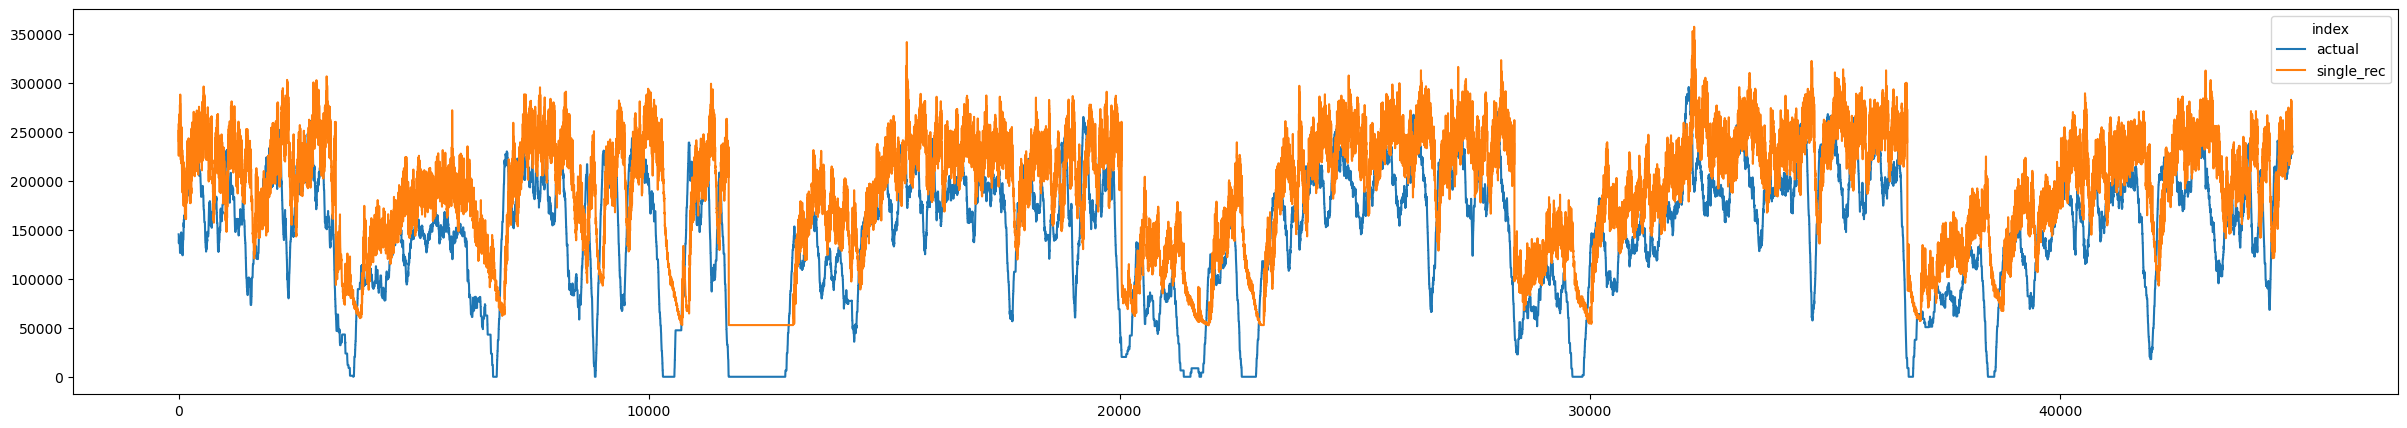

In [110]:
data.plot(figsize=(30,5))

For multiple output models

In [360]:
def multi_step(i, plot=True, ret='total', denorm=True):
    if denorm:
        actual = ss.inverse(y_test[i].detach().numpy().reshape(-1,1))
        pred = ss.inverse(model(X_test[i]).detach().numpy().reshape(-1,1))
    else:
        actual = y_test[i].detach().numpy().reshape(-1,1)
        pred = model(X_test[i]).detach().numpy().reshape(-1,1)
    df = pd.DataFrame(np.concatenate([actual, pred], axis=1)).rename({0:'actual', 1:'pred'}, axis=1)
    total = df.sum().reset_index().T
    total.columns = total.loc['index']
    total.drop('index', inplace=True)
    total.rename({0:i}, inplace=True)
    if plot:
        df.plot()
    if ret == 'total':
        return total
    elif ret == 'frame':
        return df

,actual,pred
0,20048.859375,23069.996094
1,19627.925781,23755.210938
2,19001.720703,23070.166016
3,17710.324219,21532.751953
4,17685.654297,15044.601562
...,...,...
163,20026.845703,12858.486328
164,19371.613281,13378.341797
165,18941.787109,13365.822266
166,18525.710938,14568.878906


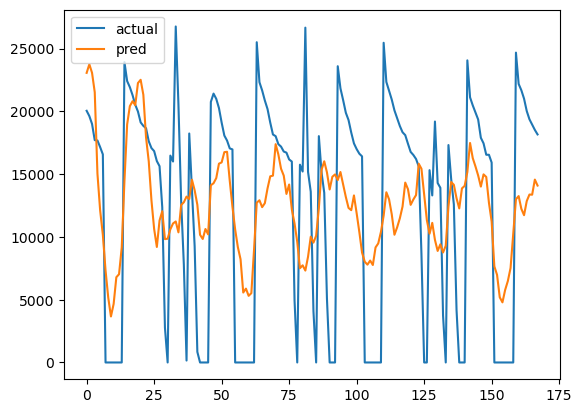

In [361]:
multi_step(700, ret='frame', denorm=True)

In [362]:
i = 0
data = pd.DataFrame()
while True:
    try: 
        df = multi_step(i, False)
        print(i)
        data = pd.concat([data, df])
        i += 1
        clear_output(wait=True)
    except:
        print('STOP')
        break

STOP


In [363]:
data

index,actual,pred
0,2108924.25,1352314.875
1,2092527.875,1358618.75
2,2101460.75,1334262.5
3,2107644.0,1348000.75
4,2112595.5,1377306.75
...,...,...
4373,1947991.5,1399261.625
4374,1964521.25,1392813.125
4375,1980900.625,1378079.0
4376,1996453.25,1363353.75


In [364]:
r2_score(data['actual'], data['pred'])

0.43902459448527786

<Axes: >

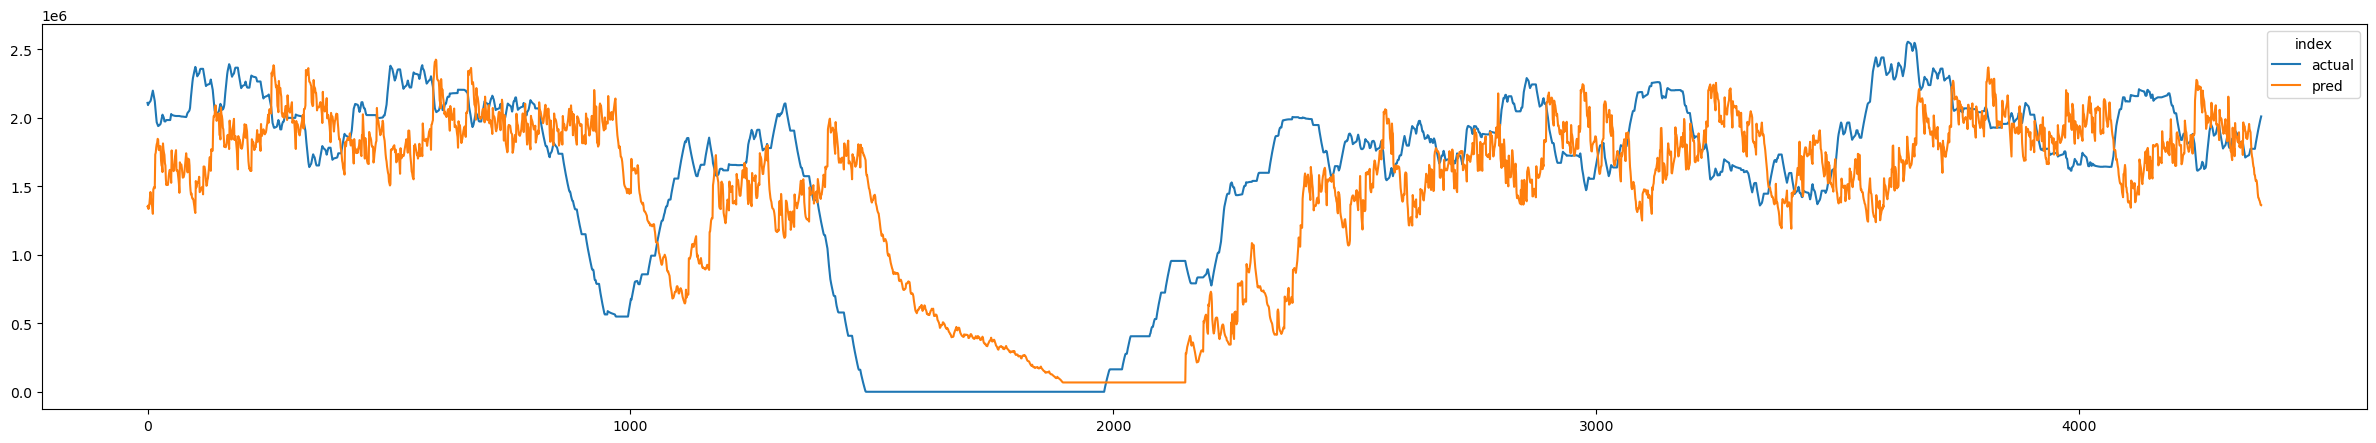

In [365]:
data.plot(figsize=(30,5))

# Save/Load Model

In [195]:
directory = input('Directory to save the model: ')
filename = input('Model Name: ')
torch.save(auto_reg, directory + filename + '.pt')

Directory to save the model: models/
Model Name: AR-IN408-SO


In [196]:
directory = input('Directory to load the model: ')
filename = input('Model Name: ')
load_mod = torch.load(directory + filename + '.pt')
model = load_mod
model.eval()

Directory to load the model: models/
Model Name: AR-IN408-SO


Linear(in_features=408, out_features=1, bias=True)